In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import argparse
import sys
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [7]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# 1. Pre-Processing

In [8]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()
    
    smi_list = list()
    logP_list = list()
    
    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))
        
    logP_list = np.asarray(logP_list).astype(float)
    
    return smi_list, logP_list

def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles)<max_length:
            smiles +=" "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        one_hot = one_hot.astype(float)
        return one_hot
        
    vocab = np.load('./vocab.npy')
    smi_total = []
    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting Data'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

class OneHotLogPDataSet(Dataset):
    def __init__(self, list_one_hot, list_logP):
        self.list_one_hot = list_one_hot
        self.list_logP = list_logP
        
    def __len__(self):
        return len(self.list_one_hot)
    
    def __getitem__(self, index):
        return self.list_one_hot[index], self.list_logP[index]
    
def partition(list_one_hot, list_logP, args):
    num_total = list_one_hot.shape[0]
    num_train = int(num_total*(1-args.test_size-args.val_size))
    num_val = int(num_total*args.val_size)
    num_test = int(num_total*args.test_size)
    
    one_hot_train = list_one_hot[:num_train]
    logP_train = list_logP[:num_train]
    one_hot_val = list_one_hot[num_train:num_train+num_val]
    logP_val = list_logP[num_train:num_train+num_val]
    one_hot_test = list_one_hot[num_total-num_test:]
    logP_test = list_logP[num_total-num_test:]
    
    train_set = OneHotLogPDataSet(one_hot_train, logP_train)
    val_set = OneHotLogPDataSet(one_hot_val, logP_val)
    test_set = OneHotLogPDataSet(one_hot_test, logP_test)
    
    partition = {
        'train' : train_set,
        'val' : val_set,
        'test' : test_set
    }
    
    return partition

In [90]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 500)
list_one_hot = smiles_to_onehot(list_smi)
dict_partition = partition(list_one_hot, list_logP, args)

# 2. Model Construction

SkipConnectionBlock can be differed by the number of SkipConnectionLayer, usage of batch normalization, and the number of filter in one layer. A SkipConnectionLayer is composed of 2D convolution layer, which does not change the dimesion of input, batch normalization layer, and ReLU activation layer. A SkipConnectionBlock is composed of n_layer SkipConnectionLayers, skip connection, and ReLU activation layer.

In [9]:
class SkipConnectionLayer(nn.Module):
    
    def __init__(self, in_planes, planes, bn=False):
        super(SkipConnectionLayer, self).__init__()
        
        self.use_bn = bn
        
        self.conv = nn.Conv2d(in_planes,
                              planes,
                              kernel_size=3,
                              stride=1,
                              padding=1,
                              bias=False)
        torch.nn.init.xavier_uniform_(self.conv.weight)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        
    def forward(self, x):  
        out = self.conv(x)
        if self.use_bn:
            out = self.bn(out)
        out = self.relu(out)
        return out

        
class SkipConnectionBlock(nn.Module):
    
    def __init__(self, n_layer, in_planes, planes, bn=False):
        super(SkipConnectionBlock, self).__init__()
                
        self.list_layer = list()
        for i in range(n_layer):
            self.list_layer.append(SkipConnectionLayer(in_planes if i==0 else planes,
                                                        planes,
                                                        bn))
        self.sc_layers = nn.Sequential(*self.list_layer)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        
        out = self.sc_layers(x)
        out += residual
        out = self.relu(out)
        
        return out

In [10]:
class BasicConv2d(nn.Module):
    
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    

class InceptionBlock(nn.Module):
    '''(32,120)->(15, 59)'''
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)
        
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
    def forward(self, x):
        branch3x3 = self.branch3x3(x)
        
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3db1_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        
        branch_pool = self.branch_pool(x)
        
        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [11]:
class Flatten(nn.Module):
    
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [12]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, activation=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim, self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = activation
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
            
        return out

In [13]:
class SkipConnectionNet(nn.Module):
    
    def __init__(self, args):
        super(SkipConnectionNet, self).__init__()
        
        self.list_block = list()
        for i in range(args.n_block):
            self.list_block.append(SkipConnectionBlock(args.n_layer,
                                                 1 if i==0 else args.n_filter,
                                                 args.n_filter,
                                                 args.bn))
        self.sc_blocks = nn.Sequential(*self.list_block)
        self.flatten = Flatten()
        pred_shape = self.predictor_shape((args.batch_size, 1, args.n_vocab, args.max_length))
        self.pred1 = Predictor(pred_shape, args.pred_dim1, nn.ReLU())
        self.pred2 = Predictor(args.pred_dim1, args.pred_dim2, nn.ReLU())
        self.pred3 = Predictor(args.pred_dim2, args.out_dim)
        
    def forward(self, x):
        out = self.sc_blocks(x)
        out = self.flatten(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out
        
    def predictor_shape(self, input_shape):       
        dummy_input = torch.zeros(input_shape)
        dummy_output = self.sc_blocks(dummy_input)
        output_shape = dummy_output.shape
        return output_shape[1]*output_shape[2]*output_shape[3]
        

# 3. Train, Validate, and Test

In [14]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_one_hot = torch.tensor(np.expand_dims(batch[0], axis=1)).to(device).float()
        list_logP = torch.tensor(batch[1]).to(device).float()
        list_logP = list_logP.view(-1,1)
        
        model.train()
        optimizer.zero_grad()
        list_pred_logP = model(list_one_hot)
        list_pred_logP.require_grad = False
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_one_hot))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [15]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_one_hot = torch.tensor(np.expand_dims(batch[0], axis=1)).to(device).float()
            list_logP = torch.tensor(batch[1]).to(device).float()
            list_logP = list_logP.view(-1,1)

            model.eval()
            list_pred_logP = model(list_one_hot)
            list_pred_logP.require_grad = False
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_one_hot))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [16]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_one_hot = torch.tensor(np.expand_dims(batch[0], axis=1)).to(device).float()
            list_logP = torch.tensor(batch[1]).to(device).float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1,1)

            list_pred_logP = model(list_one_hot)
            pred_logP_total += list_pred_logP.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(pred_logP_total)
        
    return mae, std, logP_total, pred_logP_total

In [17]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = SkipConnectionNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            pin_memory=True,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          pin_memory=True,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           pin_memory=True,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

# 4. Visualization

In [18]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)    

In [19]:
def plot_loss(df_result, var1, var2):
    def plot(x, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, 10.0)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', label='Train Loss')
    g.map(plot, 'list_val_loss', color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [20]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

# 5. Experiement

In this experiment, hyperparameter tunning will be done to the four different models depending on their number of skip connection blocks and number of filters in a skip connection block.

In [107]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0.0001
args.optim = 'Adam'
args.epoch = 10
args.n_block = 1
args.n_layer = 1
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [108]:
list_n_block = [1]
list_n_layer = [1]
var1 = "n_block"
var2 = "n_layer"

dict_result = dict()
n_iter = len(list_n_block)*len(list_n_layer)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_block in list_n_block:
    for n_layer in list_n_layer:
        args.n_block = n_block
        args.n_layer = n_layer
        args.exp_name = var1+':'+str(n_block)+'/'+var2+':'+str(n_layer)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_block vs n_layer.JSON', orient='table')

n_block:1/n_layer:1



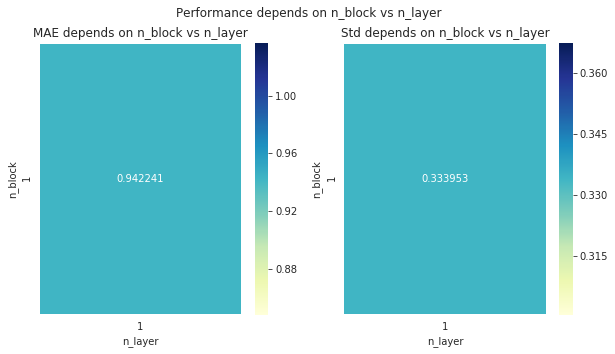

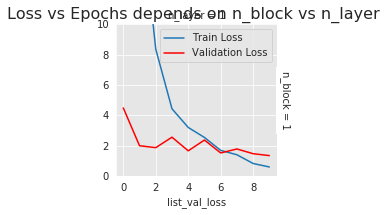

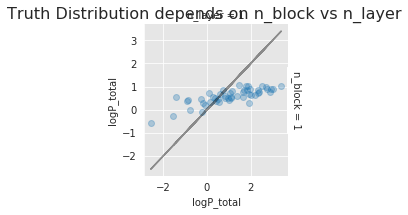

In [109]:
df_result = pd.read_json('n_block vs n_layer.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

In [68]:
df_result

,batch_size,bn,epoch,exp_name,l2_coef,list_train_loss,list_val_loss,logP_total,lr,mae,...,out_dim,pred_dim1,pred_dim2,pred_logP_total,seed,shuffle,std,test_size,time_required,val_size
n_block:1/n_layer:1,100,1,10,n_block:1/n_layer:1,0.0001,"[2793.3897317052, 15.3209118247, 7.0630840063,...","[2.7734591961, 1.6649235487, 1.4114695787, 1.3...","[-0.3470999897, 2.7163000107, 1.0395200253, 2....",0.001,0.607461,...,1,256,64,"[-1.3877065182, 0.8672604561, 0.96604371070000...",123,1,0.917989,0.1,5.445224,0.1


In [110]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'Adam'
args.epoch = 50
args.n_block = 1
args.n_layer = 1
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [111]:
list_n_block = [1, 2, 3]
list_n_layer = [1, 2, 3]
var1 = "n_block"
var2 = "n_layer"

dict_result = dict()
n_iter = len(list_n_block)*len(list_n_layer)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_block in list_n_block:
    for n_layer in list_n_layer:
        args.n_block = n_block
        args.n_layer = n_layer
        args.exp_name = var1+':'+str(n_block)+'/'+var2+':'+str(n_layer)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_block vs n_layer.JSON', orient='table')

n_block:1/n_layer:1
n_block:1/n_layer:2
n_block:1/n_layer:3
n_block:2/n_layer:1
n_block:2/n_layer:2
n_block:2/n_layer:3
n_block:3/n_layer:1
n_block:3/n_layer:2
n_block:3/n_layer:3



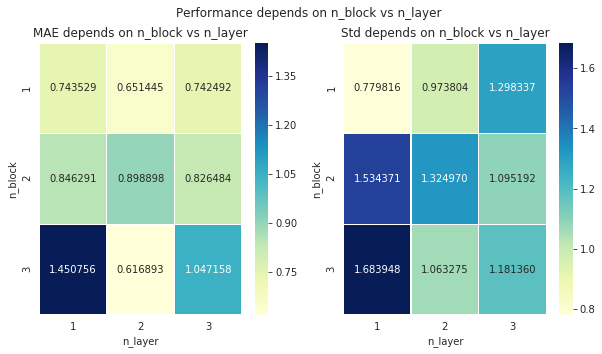

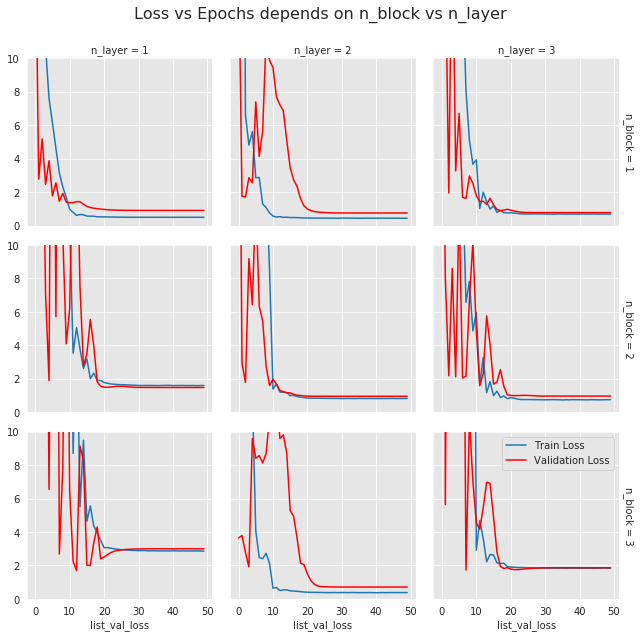

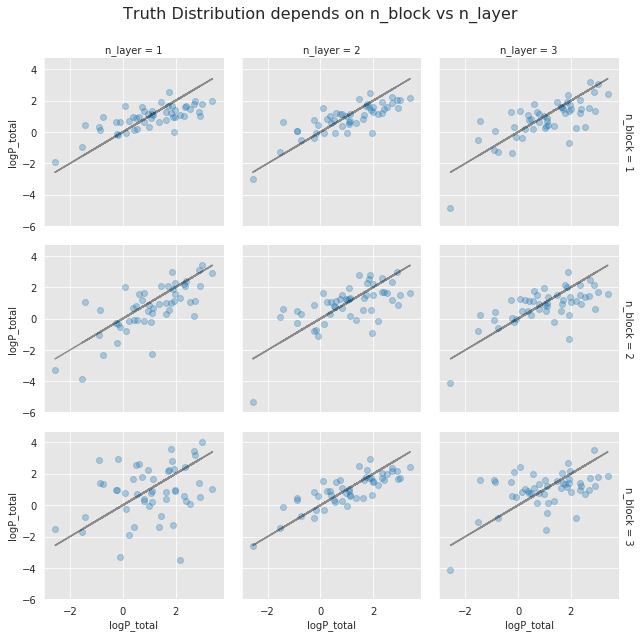

In [112]:
df_result = pd.read_json('n_block vs n_layer.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

In [113]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'Adam'
args.epoch = 50
args.n_block = 1
args.n_layer = 3
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [114]:
list_lr = [0.001, 0.0001, 0.00001, 0.000001]
list_l2_coef = [0.001, 0.0001, 0.00001, 0.000001]
var1 = "lr"
var2 = "l2_coef"

dict_result = dict()
n_iter = len(list_lr)*len(list_l2_coef)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for l2_coef in list_l2_coef:
        args.lr = lr
        args.l2_coef = l2_coef
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(l2_coef)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs l2_coef.JSON', orient='table')

lr:0.001/l2_coef:0.001
lr:0.001/l2_coef:0.0001
lr:0.001/l2_coef:1e-05
lr:0.001/l2_coef:1e-06
lr:0.0001/l2_coef:0.001
lr:0.0001/l2_coef:0.0001
lr:0.0001/l2_coef:1e-05
lr:0.0001/l2_coef:1e-06
lr:1e-05/l2_coef:0.001
lr:1e-05/l2_coef:0.0001
lr:1e-05/l2_coef:1e-05
lr:1e-05/l2_coef:1e-06
lr:1e-06/l2_coef:0.001
lr:1e-06/l2_coef:0.0001
lr:1e-06/l2_coef:1e-05
lr:1e-06/l2_coef:1e-06



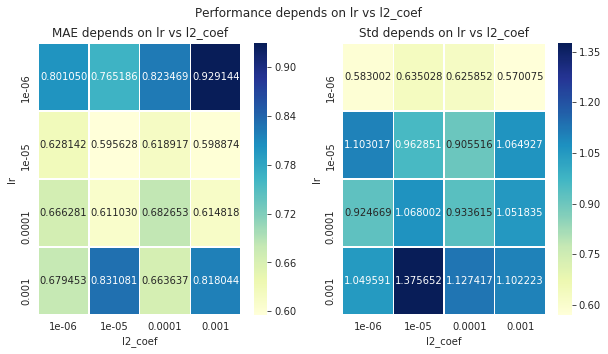

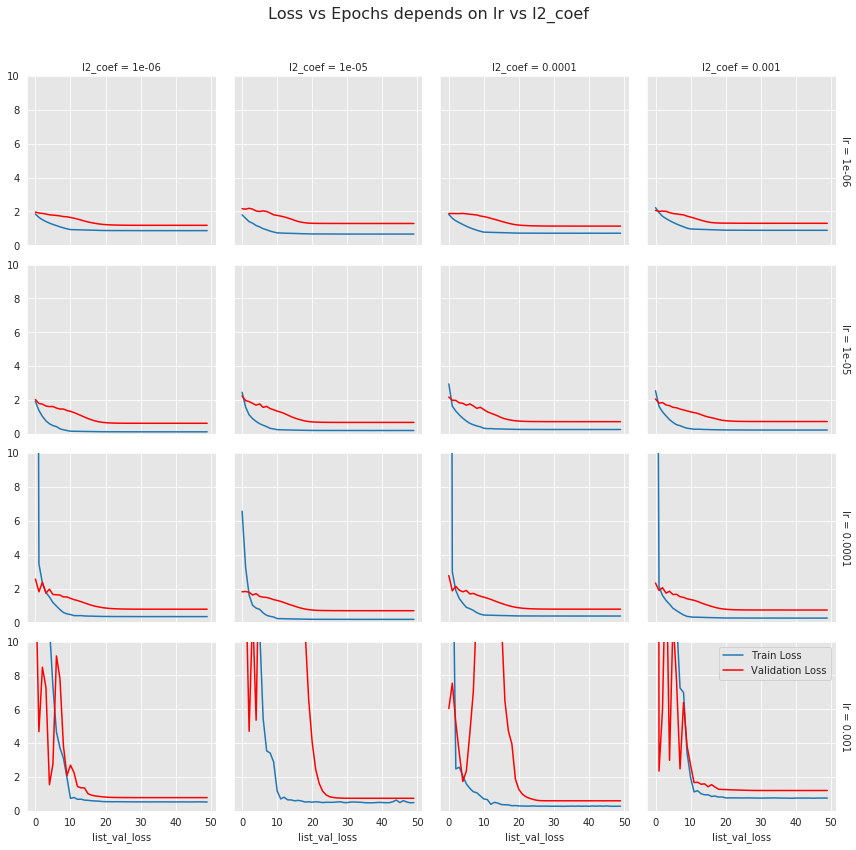

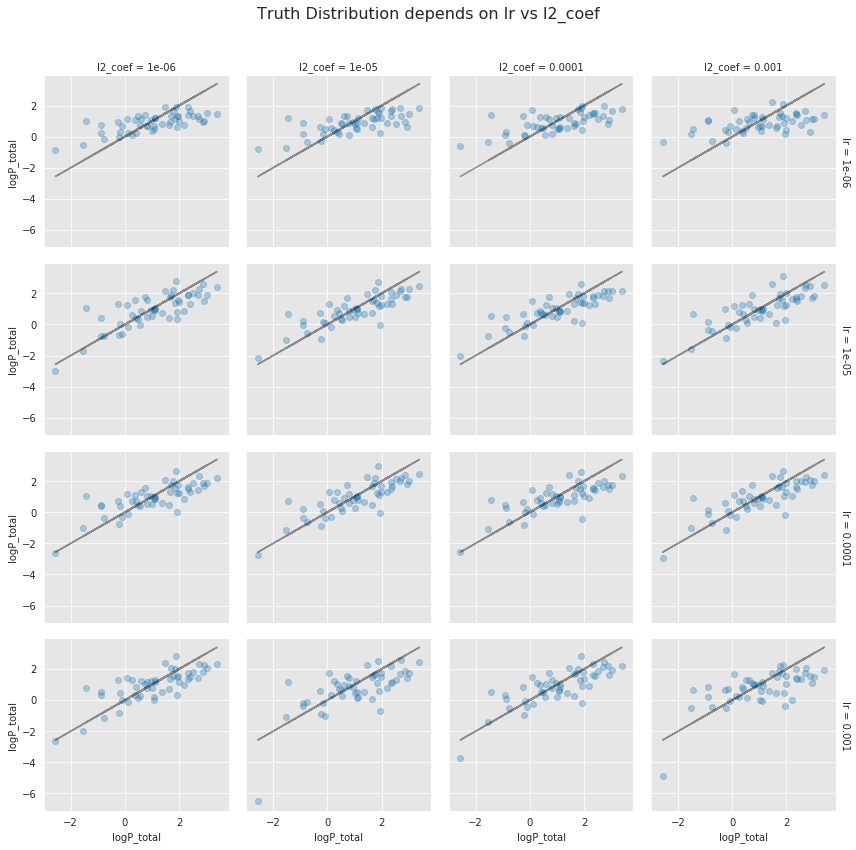

In [115]:
df_result = pd.read_json('lr vs l2_coef.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

In [116]:
args.batch_size = 100
args.lr = 0.00001
args.l2_coef = 0.00001
args.optim = 'Adam'
args.epoch = 50
args.n_block = 1
args.n_layer = 3
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [117]:
list_pred_dim1 = [64, 128, 256, 512]
list_pred_dim2 = [16, 32, 64, 128]
var1 = "pred_dim1"
var2 = "pred_dim2"

dict_result = dict()
n_iter = len(list_pred_dim1)*len(list_pred_dim2)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for pred_dim1 in list_pred_dim1:
    for pred_dim2 in list_pred_dim2:
        args.pred_dim1 = pred_dim1
        args.pred_dim2 = pred_dim2
        args.exp_name = var1+':'+str(pred_dim1)+'/'+var2+':'+str(pred_dim2)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('pred_dim1 vs pred_dim2.JSON', orient='table')

pred_dim1:64/pred_dim2:16
pred_dim1:64/pred_dim2:32
pred_dim1:64/pred_dim2:64
pred_dim1:64/pred_dim2:128
pred_dim1:128/pred_dim2:16
pred_dim1:128/pred_dim2:32
pred_dim1:128/pred_dim2:64
pred_dim1:128/pred_dim2:128
pred_dim1:256/pred_dim2:16
pred_dim1:256/pred_dim2:32
pred_dim1:256/pred_dim2:64
pred_dim1:256/pred_dim2:128
pred_dim1:512/pred_dim2:16
pred_dim1:512/pred_dim2:32
pred_dim1:512/pred_dim2:64
pred_dim1:512/pred_dim2:128



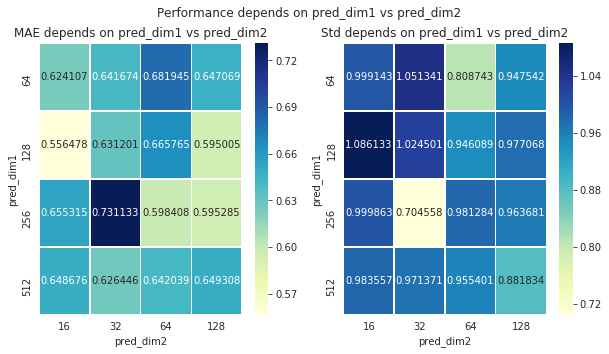

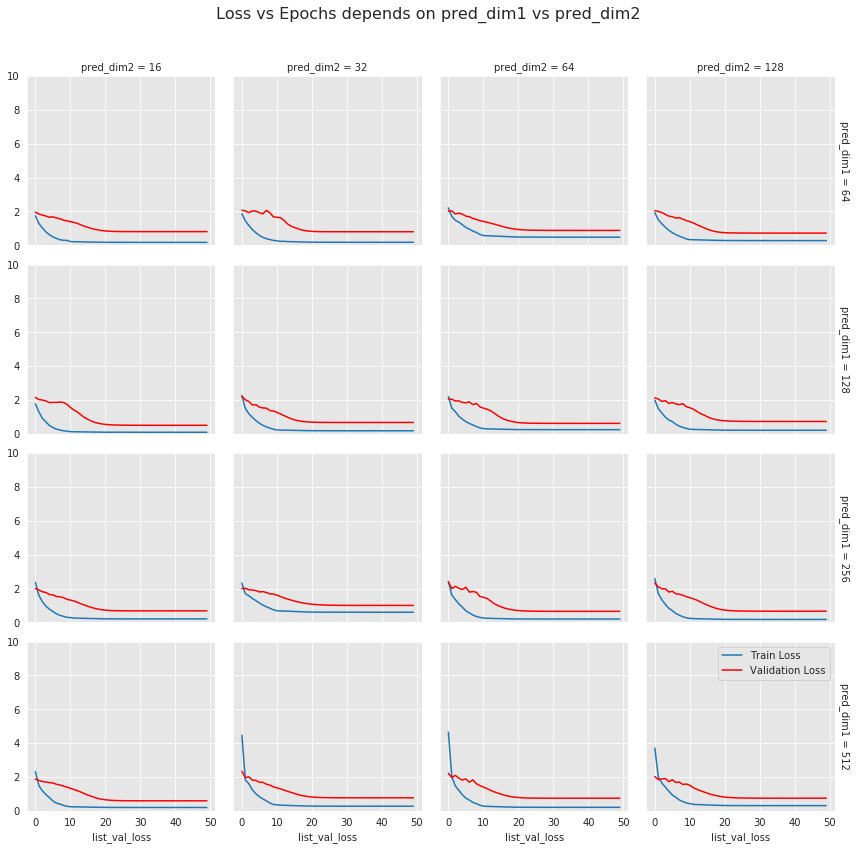

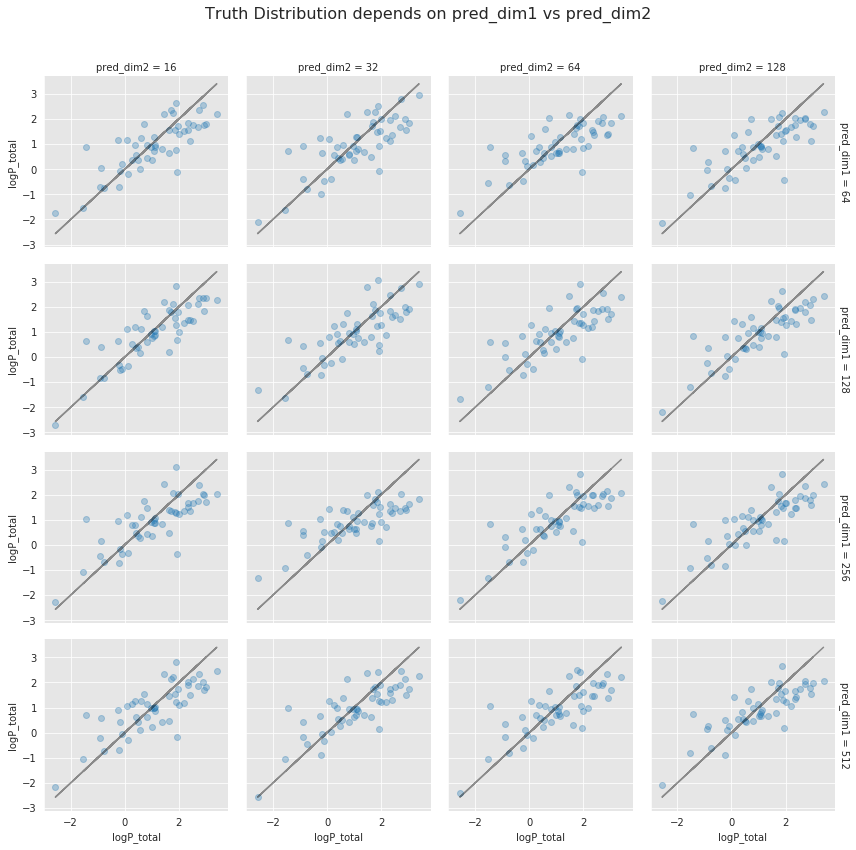

In [118]:
df_result = pd.read_json('pred_dim1 vs pred_dim2.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

In [119]:
args.batch_size = 100
args.lr = 0.00001
args.l2_coef = 0.00001
args.optim = 'Adam'
args.epoch = 50
args.n_block = 1
args.n_layer = 3
args.n_filter = 64
args.pred_dim1 = 256
args.pred_dim2 = 64
args.out_dim = 1
args.bn = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [120]:
list_n_filter = [16, 32, 64, 128]
list_bn = [True, False]
var1 = "n_filter"
var2 = "bn"

dict_result = dict()
n_iter = len(list_n_filter)*len(list_bn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_filter in list_n_filter:
    for bn in list_bn:
        args.n_filter = n_filter
        args.bn = bn
        args.exp_name = var1+':'+str(n_filter)+'/'+var2+':'+str(bn)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_filter vs bn.JSON', orient='table')

n_filter:16/bn:True
n_filter:16/bn:False
n_filter:32/bn:True
n_filter:32/bn:False
n_filter:64/bn:True
n_filter:64/bn:False
n_filter:128/bn:True
n_filter:128/bn:False



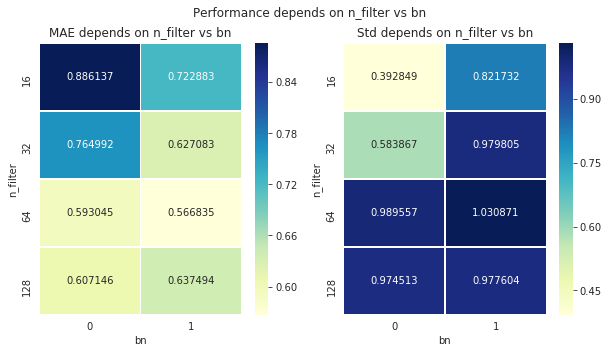

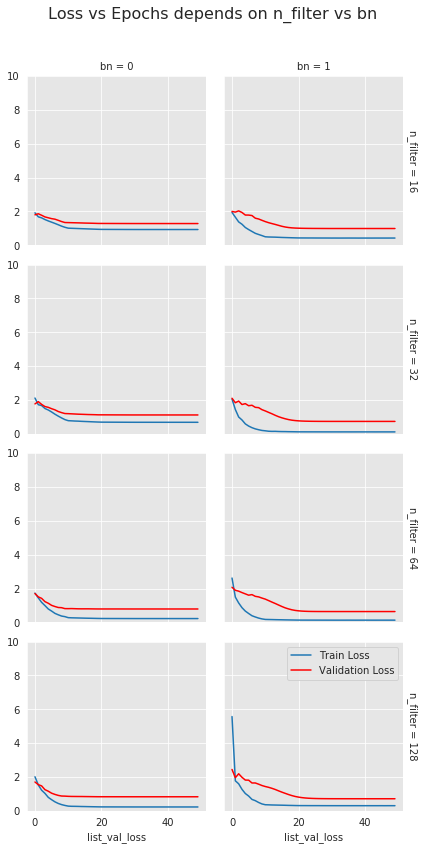

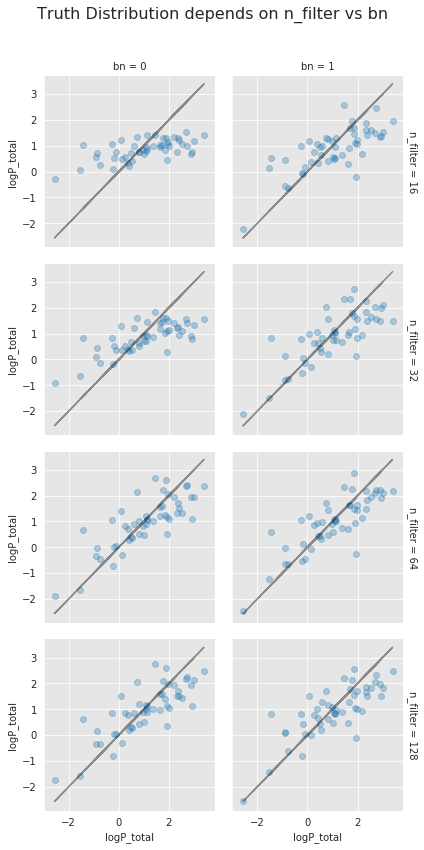

In [121]:
df_result = pd.read_json('n_filter vs bn.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

In [122]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 50000)
list_one_hot = smiles_to_onehot(list_smi)
dict_partition = partition(list_one_hot, list_logP, args)

In [123]:
args.batch_size = 100
args.lr = 0.00001
args.l2_coef = 0.00001
args.optim = 'Adam'
args.epoch = 100
args.n_block = 3
args.n_layer = 2
args.n_filter = 64
args.pred_dim1 = 128
args.pred_dim2 = 16
args.out_dim = 1
args.bn = True
args.n_vocab = 32
args.max_length = 120
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [124]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result.JSON', orient='table')

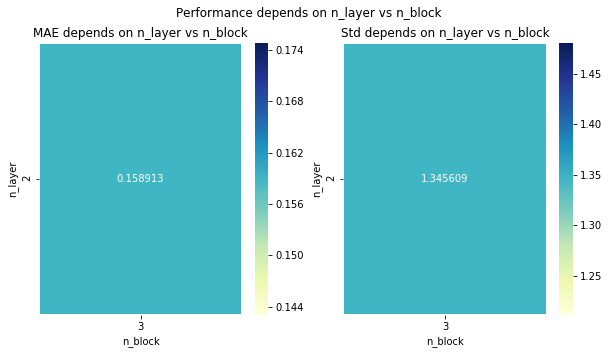

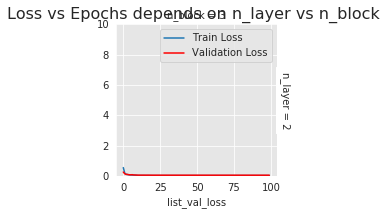

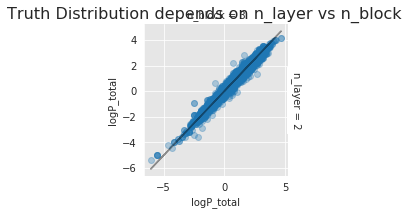

In [21]:
df_result = pd.read_json('result.JSON', orient='table')

var1 = 'n_layer'
var2 = 'n_block'

plot_performance(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

In [127]:
df_result = pd.read_json('result.JSON', orient='table')
df_result

,batch_size,bn,epoch,exp_name,gamma,l2_coef,list_train_loss,list_val_loss,logP_total,lr,...,pred_dim1,pred_dim2,pred_logP_total,seed,shuffle,std,step_size,test_size,time_required,val_size
result,100,1,100,result,0.1,0.00001,"[0.5463287161, 0.1749515308, 0.1088894789, 0.0...","[0.2524474955, 0.1395128621, 0.0986517366, 0.0...","[0.0076199998, 1.0803200006, 1.8565399647, 0.3...",0.00001,...,128,16,"[0.0919630677, 0.9853291512000001, 1.945717334...",123,1,1.345609,10,0.1,6175.633479,0.1
